## Тестовое задание для VKLab

Список литературы:
    1. https://arxiv.org/pdf/1503.02531.pdf
    2. https://arxiv.org/pdf/2004.05937v3.pdf

Зависимости:
    1. https://github.com/pabloppp/pytorch-tools

### Постановка задачи

Целью этого тестового задания я ставлю разобраться с методом Knowledge Distillation (KD) и самостоятельно протестировать его на практике. 

### Подготовительные процедуры

In [1]:
import numpy as np
import torch.nn as nn
import torch
import torchvision
import random

In [2]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data import RandomSampler, SequentialSampler
from torchvision import datasets, models, transforms
from torchtools.optim import Ralamb
import os

In [3]:
# обеспечим воспроизводимость результатов

def set_seed(seed = 1234):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Определим модель-учителя

Я сфокусируюсь на моделях компьютерного зрения, взяв в качестве датасета предложенный организаторами imagewoof, а в качестве модели-учителя - pretrained ResNet50.

In [5]:
num_classes = 10
batch_size = 128

In [8]:
def initialize_model(num_classes):
    model = models.resnet50(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    
    return model, input_size

In [6]:
model_teacher, input_size = initialize_model(num_classes)

In [7]:
from torchtools.optim import Ranger

model_teacher = model_teacher.to(device)

teacher_params = []
for name, param in model_teacher.named_parameters():
    if param.requires_grad == True:
        teacher_params.append(param)

optimizer_teacher = Ranger(teacher_params, lr=0.001)

### Подготовка данных

In [56]:
data_dir = 'imagewoof2-320/'

In [59]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [60]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8) for x in ['train', 'val', 'test']}

### Функция для обучения

Я попытаюсь продемонстрировать простейший способ Knowledge Distillation, предложенный Hinton et al. 
А именно, при обучении модели-ученика, будем использовать Loss-функцию, учитывающую предсказания модели-учителя:

$$ L(x,W)=\alpha H(y, \sigma (z_s; T=1)+ \beta  H(\sigma(z_t;T =\tau),\sigma(z_s,T = \tau)) $$

где x это входные данные, W - параметры модели-ученика, H - функция потерь (например, кросс-энтропия), y - метки классов, $\sigma$ - функция Softmax, параметризаванная температурой T, $\alpha$ and $\beta$ - коэффиценты, $z_s$ and $z_t$ - logits студента и ученика.

У меня $$\beta = 1 - \alpha$$

In [208]:
def studentLossFn(teacher_pred, student_pred, y, T, alpha):
    if (alpha > 0):
        loss = F.kl_div(F.log_softmax(student_pred / T, dim=1), F.softmax(teacher_pred / T, dim=1), reduction='batchmean') * (T ** 2) * alpha + F.cross_entropy(student_pred, y) * (1 - alpha)
    else:
        loss = F.cross_entropy(student_pred, y)
    return loss

In [ ]:
def train(model_type, model, dataloaders, criterion, optimizer, num_epochs, teacher_model=None):
    since = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    if model_type == 'teacher' or model_type == 'student_solo':
                        loss = criterion(outputs, labels)
                    elif model_type == 'student':
                        teacher_pred = teacher_model(inputs)
                        loss = studentLossFn(teacher_pred, outputs, labels, T=10, alpha=0.1)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    # backprop
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), model_type + 'saved_weights_v1_'+ 'e_' + str(epoch) + '.pt')
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        
        print()
        
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### Обучение модели-учителя

Проведем fine-tuning модели ResNet50 для задачи классификации пород собак (датасет - imagewoof).

In [ ]:
import time
import copy

In [ ]:
num_epochs_teacher = 20

In [ ]:
# Setup the loss fxn
criterion_teacher = nn.CrossEntropyLoss()

# Train and evaluate
best_teacher, teacher_hist = train('teacher', 
                                   model_teacher, 
                                   dataloaders_dict, 
                                   criterion_teacher, 
                                   optimizer_teacher, 
                                   num_epochs_teacher,
                                   None)

### Обучение модели ученика

В качетсве модели-ученика возьмем небольшую CNN.

In [42]:
import torch.nn.functional as F

In [43]:
class StudentNetwork(nn.Module):
    def __init__(self):
        super(StudentNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
model_student = StudentNetwork()
model_student = model_student.to(device)

optimizer_student = Ranger(model_student.parameters(), lr=0.001)

In [ ]:
best_student, student_hist = train('student', 
                                           model_student, 
                                           dataloaders_dict, 
                                           criterion,
                                           optimizer_student, 
                                           num_epochs=500, 
                                           teacher_model=model_teacher)

### Маленькая модель в соло(без учителя)

In [31]:
student_net_solo = StudentNetwork()
student_net_solo = student_net_solo.to(device)

optimizer_student_solo = Ranger(student_net_solo.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
best_student_solo, solo_hist = train_solo('student_solo_', 
                                                          student_net_solo, 
                                                          dataloaders_dict, 
                                                          criterion, 
                                                          optimizer_student_solo, 
                                                          num_epochs=500,
                                                          None)

### Первые результаты

После $500$ эпох обучения этого эксперимента мы можем наблюдать следующие результаты:
    1. Для обеих моделей на валидации мы достигли значения accuracy 0.54
    2. В борьбе за доли процента в ходе валидации все-таки победила модель, пользующаяся поддержкой учителя: 
       0.543 VS 0.542
    3. Во время обучения соло-модель делала больше промахов на валидации

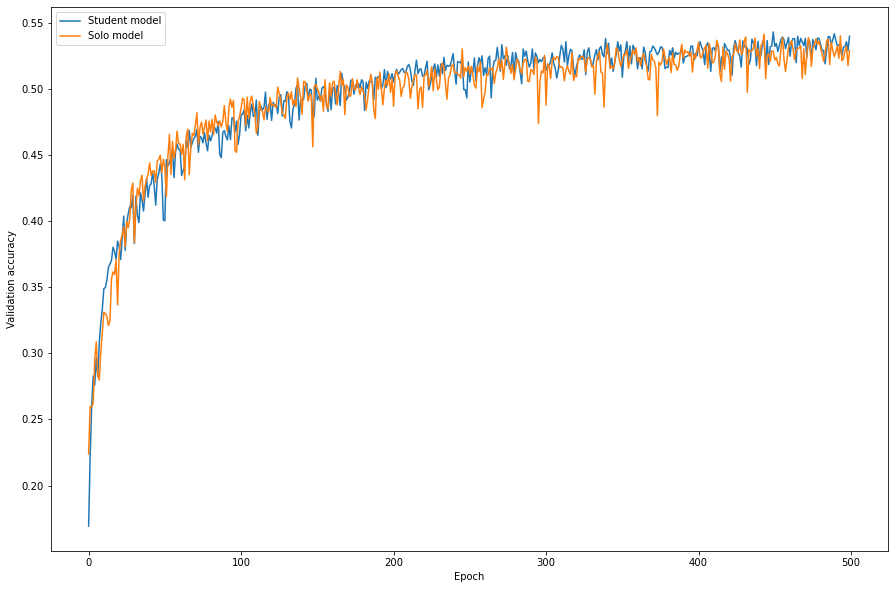

In [50]:
import matplotlib.pyplot as plt

axis_x = np.arange(0, 500)

plt.figure(figsize=(15, 10))
plt.plot(axis_x, student_hist, label='Student model')
plt.plot(axis_x, solo_hist, label='Solo model')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

Теперь посмотрим, как покажут себя две модели на тестовых данных

In [99]:
def test(model, dataloaders):
    model.eval()
    
    mistakes = 0
    total = 0
    correct = 0

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        with torch.no_grad():
            preds = model(inputs).to('cpu')
            _, predicted = torch.max(preds.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            mistakes += (predicted != labels).sum().item()
    
    return 100 * correct / total, mistakes, total

Соло-модель:

In [101]:
solo_acc, solo_mistakes, total = test(best_student_solo, dataloaders_dict)
print('Accuracy: ', solo_acc)
print('Mistakes: ', solo_mistakes, ' out of ', total)

Accuracy:  51.228070175438596
Mistakes:  139  out of  285


Модель-ученик:

In [102]:
student_acc, student_mistakes, total = test(best_student, dataloaders_dict)
print('Accuracy: ', student_acc)
print('Mistakes: ', student_mistakes, ' out of ', total)

Accuracy:  56.14035087719298
Mistakes:  125  out of  285


Я получил результат, схожий с полученным в оригинальной статье Hinton et al, пусть и не такой впечатляющий. Точнее, мне удалось повысить обобщаемость модели-ученика путем передачи ей dark knowledge от модели-учителя. 

### Гиперпараметры

В предыдущих экспериментах я использовал значения $T=10$  и  $\alpha=0.1$ (доля обычного CrossEntropyLoss'a). 
Посмотрим, как изменится результат в зависимости от изменения этих параметров.

Для сокращения времени эксперимента я сокращу количество эпох до 100.

In [104]:
T_params = [2, 4, 8, 10, 16, 20]
alpha_params = [0.1, 0.3, 0.5]

In [ ]:
accuracies = np.zeros((6, 3))
mistakes = np.zeros((6, 3))

val_acc_histories = []

for i in range(6):
    for j in range(3):
        student = StudentNetwork()
        student = student.to(device)

        optimizer = Ranger(student.parameters(), lr=0.001)
        
        student, student_val_acc_hist = train('student_T' + str(T_params[i]) + '_alpha' + str(alpha_params[j]), 
                                              student, 
                                              dataloaders_dict,
                                              optimizer, 
                                              num_epochs=100,
                                              teacher_model=model_ft,
                                              T=T_params[i],
                                              alpha=alpha_params[j])
        
        val_acc_histories.append(student_val_acc_hist)
        
        cur_model_acc, cur_model_mistakes, total = test(student, dataloaders_dict)
        
        accuracies[i][j] = cur_model_acc
        mistakes[i][j] = cur_model_mistakes

Посмотрим на результаты эксперимента

In [166]:
import seaborn as sns

[Text(373.36363636363626, 0.5, 'T'),
 Text(0.5, 15.0, 'alpha'),
 Text(0.5, 1.0, 'Number of mistakes w.r.t.')]

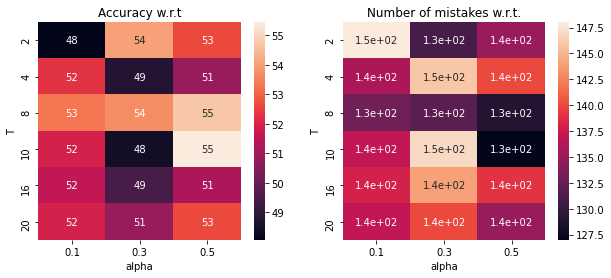

In [204]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
acc_map = sns.heatmap(accuracies,
                      ax=ax[0],
                      annot=True, 
                      xticklabels=alpha_params, 
                      yticklabels=T_params)
acc_map.set(title='Accuracy w.r.t', xlabel='alpha', ylabel='T')

mistakes_map = sns.heatmap(mistakes,
                      ax=ax[1],
                      annot=True, 
                      xticklabels=alpha_params, 
                      yticklabels=T_params)
mistakes_map.set(title='Number of mistakes w.r.t.', xlabel='alpha', ylabel='T')

Из результатов эксперимента видно, что наилучший результат достигается при 'среднем' значении $T=10$ и параметре $\alpha=0.5$, то есть когда лосс с ground truth labels и предсказаниями модели-учителя учитываются с равными весами. 

Подбор параметров $T$ и $\alpha$ позволил за 100 эпох достичь улучшения на $4\%$ по сравнению с моделью, обучавшейся без помощи учителя. 

In [ ]:
solo_net100 = StudentNetwork()
solo_net100 = solo_net100.to(device)

optim_solo100 = Ranger(solo_net100.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

solo_net100, _ = train_solo('solo_100', solo_net100, dataloaders_dict, criterion, optim_solo100, num_epochs=100)

solo100_acc, solo_acc_mistakes, total = test(solo_net100, dataloaders_dict)
print(solo100_acc)

### Итоги

В ходе выполнения этого тестового задания я познакомился с простейшим из методов Knowledge Distillation и экспериментально подтвердил его действенность.

С помощью передачи знаний от большой модели-учителя маленькой модели-ученику мне удалось достичь прироста метрики Accuracy на $4\%$.